In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [134]:
PREVIOUS_SEASONS_MEN = True
PREVIOUS_SEASONS_WOMEN  = True 
USE_GPU = True # Turn on GPU P100 if USE_GPU=True
USE_ADDITONAL_COLUMN = False
USE_SIMPLEFLAG = False
USE_YEAR_WINFLAG = False
USE_DAYS_WINFLAG = True

https://www.ncaa.com/news/basketball-men/article/2024-05-03/2025-march-madness-mens-ncaa-tournament-schedule-dates
(2025 NCAA schedule)

In [135]:
import os

import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
from scipy.interpolate import UnivariateSpline
from sklearn import preprocessing
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import KFold
from tqdm import tqdm
pd.set_option("display.max_column", 200)
pd.set_option("display.max_rows", 200)
# print(os.listdir("../input"))
xgb.__version__ # I used '1.2.0-SNAPSHOT'

'2.0.3'

## Historical match data inquiry


In [136]:

DATA_PATH = "/kaggle/input/march-machine-learning-mania-2025/"
tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
#  Data Inquiry for 2025
if 2025 not in seeds["Season"].unique():
    print("Provisionally processed as of 2024, when 2025 seed data does not exist")
    
    # 2024 Season Data copy
    seeds_2025 = seeds[seeds["Season"] == 2024].copy()
    seeds_2025["Season"] = 2025  # Change Seasn 2025
    
    # Combine with source data
    seeds = pd.concat([seeds, seeds_2025], ignore_index=True)
    
    print(" Added 2025 Season Data.")
else:
    print(" Already exist 2025 Season Data")
    

print(seeds.tail(10)) 
regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

 Already exist 2025 Season Data
      Season Seed  TeamID
4360    2025  Z07    3329
4361    2025  Z08    3143
4362    2025  Z09    3280
4363    2025  Z10    3355
4364    2025  Z11    3293
4365    2025  Z12    3193
4366    2025  Z13    3251
4367    2025  Z14    3195
4368    2025  Z15    3117
4369    2025  Z16    3422


In [137]:
def prepare_data(df_data, use_additional_column=False):
    df = df_data.copy()
    df.rename(columns={'WLoc': 'location'}, inplace=True)
    
    # Create Data for swap
    dfswap = df[[
        'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT', 
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
        'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'
    ]]

    #  additional_columns list
    additional_cols = ['WEFFG', 'WEFFG3', 'WDARE', 'WTOQUETOQUE',
                       'LEFFG', 'LEFFG3', 'LDARE', 'LTOQUETOQUE']
    
    #  Whether additional data columns are reflected
    if use_additional_column:
        df = df.assign(**{col: df[col.split('_')[1]] / df[col.split('_')[1] + 'A'] for col in additional_cols})
        dfswap = dfswap.assign(**{col: dfswap[col.split('_')[1]] / dfswap[col.split('_')[1] + 'A'] for col in additional_cols})

    #  Win Team(W) → T1, LoseTeam(L) → T2
    df.columns = df.columns.str.replace('W', 'T1_')
    df.columns = df.columns.str.replace('L', 'T2_')

    #  dfswap(Lose team ->1, Win Team ->T2)
    dfswap.columns = dfswap.columns.str.replace('L', 'T1_')
    dfswap.columns = dfswap.columns.str.replace('W', 'T2_')

    # combined Swap Data
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    
    #  Converting Home Team to Numbers: N → 0, H → 1, A → -1
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output['location'] = output['location'].astype(int)

    output['PointDiff'] = output['T1_Score'] - output['T2_Score']


    if use_additional_column:
        output['T1_EFFG'] = output['T1_FGM'] / output['T1_FGA']
        output['T1_EFFG3'] = output['T1_FGM3'] / output['T1_FGA3']
        output['T1_DARE'] = output['T1_FGM3'] / output['T1_FGM']
        output['T1_TOQUETOQUE'] = output['T1_Ast'] / output['T1_FGM']
        
        output['T2_EFFG'] = output['T2_FGM'] / output['T2_FGA']
        output['T2_EFFG3'] = output['T2_FGM3'] / output['T2_FGA3']
        output['T2_DARE'] = output['T2_FGM3'] / output['T2_FGM']
        output['T2_TOQUETOQUE'] = output['T2_Ast'] / output['T2_FGM']

        # if additional results == Nan then fill in 0 
        cols_to_fill = ['T1_EFFG','T1_EFFG3','T1_DARE','T1_TOQUETOQUE',
                        'T2_EFFG','T2_EFFG3','T2_DARE','T2_TOQUETOQUE']
        output[cols_to_fill] = output[cols_to_fill].fillna(0.0)

    return output


In [138]:

#Additional Parameter
'''
EFFG → "Team's effective field goal percentage"
EFFG3 → "Team's three-point shooting accuracy"
DARE → "Percentage of three-point shots among all made field goals"
TOQUETOQUE → "Assist-to-field-goal ratio"
'''
if USE_ADDITONAL_COLUMN == True:
    regular_results['WEFFG'] = regular_results['WFGM'] / regular_results['WFGA']
    regular_results['WEFFG3'] = regular_results['WFGM3'] / regular_results['WFGA3']
    regular_results['WDARE'] = regular_results['WFGM3'] / regular_results['WFGM']
    regular_results['WTOQUETOQUE'] = regular_results['WAst'] / regular_results['WFGM']
    
    regular_results['LEFFG'] = regular_results['LFGM'] / regular_results['LFGA']
    regular_results['LEFFG3'] = regular_results['LFGM3'] / regular_results['LFGA3']
    regular_results['LDARE'] = regular_results['LFGM3'] / regular_results['LFGM']
    regular_results['LTOQUETOQUE'] = regular_results['LAst'] / regular_results['LFGM']
    
    
    tourney_results['WEFFG'] = tourney_results['WFGM'] / tourney_results['WFGA']
    tourney_results['WEFFG3'] = tourney_results['WFGM3'] / tourney_results['WFGA3']
    tourney_results['WDARE'] = tourney_results['WFGM3'] / tourney_results['WFGM']
    tourney_results['WTOQUETOQUE'] = tourney_results['WAst'] / tourney_results['WFGM']
    
    tourney_results['LEFFG'] = tourney_results['LFGM'] / tourney_results['LFGA']
    tourney_results['LEFFG3'] = tourney_results['LFGM3'] / tourney_results['LFGA3']
    tourney_results['LDARE'] = tourney_results['LFGM3'] / tourney_results['LFGM']
    tourney_results['LTOQUETOQUE'] = tourney_results['LAst'] / tourney_results['LFGM']
    cols_with_ratios = [
    'WEFFG','WEFFG3','WDARE','WTOQUETOQUE',
    'LEFFG','LEFFG3','LDARE','LTOQUETOQUE'
    ]
    


## Preparing Learning Data



In [139]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [140]:
base_cols = [
    'T1_Score', 'T2_Score',
    'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3',
    'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF',
    'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3',
    'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',
    'PointDiff'
]

additional_cols = [
    'T1_EFFG', 'T1_EFFG3', 'T1_DARE', 'T1_TOQUETOQUE',
    'T2_EFFG', 'T2_EFFG3', 'T2_DARE', 'T2_TOQUETOQUE'
]

if USE_ADDITONAL_COLUMN:
    boxscore_cols = base_cols + additional_cols
else:
    boxscore_cols = base_cols
if USE_SIMPLEFLAG:
    boxscore_cols = ['T1_Score', 'T2_Score', 'PointDiff']

## Create a stat as the average of regular-season games


In [141]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()
season_statistics.columns = [f"{col[0]}_mean" if col[1] == "mean" else col[0] for col in season_statistics.columns]
season_statistics.head(3)

<ipython-input-141-1d7ed903c056>:1: FutureWarning: The provided callable <function mean at 0x7be434260a60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()


,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714


In [142]:

def get_mean_of_3_season(val_2ps, val_1ps, val_0ps, 
                         weight_2=1, weight_1=2, weight_0=3, 
                         degree_weight=1.0
                         ):
    weight_2 = weight_2**degree_weight
    weight_1 = weight_1**degree_weight
    weight_0 = weight_0**degree_weight
    if val_2ps == 0  and val_1ps == 0:
        return val_0ps
    elif val_2ps == 0:
        return (val_1ps*weight_2 + val_0ps*weight_1)/(weight_2 + weight_1)
    else:
        sum_of_values = val_2ps*weight_2 + val_1ps*weight_1 + val_0ps*weight_0
        return sum_of_values/(weight_2 + weight_1 + weight_0)

def get_3_feature(df_team, feature):
    value_2_seasons_ago = 0
    value_1_season_ago = 0
    value_0_season_ago = 0
    for _, val in df_team.iterrows():
        value_2_seasons_ago = value_1_season_ago
        value_1_season_ago = value_0_season_ago
        value_0_season_ago = val[feature]
    return value_2_seasons_ago, value_1_season_ago, value_0_season_ago

def write_mean_of_3_seasons(df, features, degree_weight=1.0):
    df_copy = df.copy()
    suffix = "_mn3s"
    

    for ft in features:
        df_copy[ft + suffix] = 0.0  

    for idx, val in tqdm(df_copy.iterrows(), total=len(df_copy)):
        team = val.T1_TeamID
        season = val.Season
        df_team = df_copy[(df_copy.T1_TeamID == team)&
                          (df_copy.Season <= season)&
                          (df_copy.Season > season-3)]
        
        for ft in features:
            val_2ps, val_1ps, val_0ps = get_3_feature(df_team, ft)
            ft_mean_3 = get_mean_of_3_season(val_2ps, val_1ps, val_0ps, degree_weight=degree_weight)
            

            df_copy.loc[idx, ft + suffix] = float(ft_mean_3)  

    return df_copy


In [143]:
#Make two copies of the data
if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_Score_mean", "T1_FGA_mean",  "T1_FGA3_mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, degree_weight=1.0
    )
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
else:
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1[1000:1003]

100%|██████████| 13583/13583 [00:24<00:00, 546.17it/s]


,Season,T1_TeamID,T1_Score_mean,T2_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s
1000,2006,1122,71.870968,71.258065,24.677419,54.193548,5.483871,16.387097,10.516129,14.032258,14.419355,7.000000,18.580645,25.548387,56.612903,6.548387,19.516129,12.161290,13.161290,15.290323,7.419355,2.548387,0.612903,68.402746,53.584869,16.892953
1001,2006,1123,62.538462,65.461538,22.230769,52.192308,5.307692,14.769231,11.384615,11.500000,14.423077,6.846154,22.846154,20.076923,47.000000,6.115385,16.000000,9.500000,12.230769,14.730769,6.115385,3.230769,-2.923077,66.213014,54.194258,16.272402
1002,2006,1124,63.176471,72.529412,21.588235,54.294118,7.882353,21.176471,10.000000,10.941176,15.235294,6.176471,20.000000,25.117647,56.764706,6.411765,17.764706,13.411765,15.352941,12.705882,6.470588,4.058824,-9.352941,63.841322,52.992738,20.748729


In [144]:
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

# We don't have the box score statistics in the prediction bank. So drop it.
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
season_statistics_T1.head(3)

,Season,T1_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000,57.250000,39.785714,20.821429
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630,78.777778,55.851852,16.074074
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714,69.285714,57.178571,19.857143


In [145]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

#  T1 팀의 정규시즌 전체 승률 계산
season_win_stats_T1 = regular_data.copy()
season_win_stats_T1['win'] = np.where(season_win_stats_T1['PointDiff'] > 0, 1, 0)
season_win_stats_T1 = season_win_stats_T1.groupby(['Season', 'T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_season')

#  T2 팀의 정규시즌 전체 승률 계산
season_win_stats_T2 = regular_data.copy()
season_win_stats_T2['win'] = np.where(season_win_stats_T2['PointDiff'] < 0, 1, 0)
season_win_stats_T2 = season_win_stats_T2.groupby(['Season', 'T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_season')


In [146]:
season_win_stats_T2

,Season,T2_TeamID,T2_win_ratio_season
0,2003,1102,0.428571
1,2003,1103,0.481481
2,2003,1104,0.607143
3,2003,1105,0.269231
4,2003,1106,0.464286
...,...,...,...
13578,2025,3476,0.516129
13579,2025,3477,0.185185
13580,2025,3478,0.225806
13581,2025,3479,0.250000


## Allocation of regular season stat to tournament results

In [147]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
if USE_YEAR_WINFLAG:
    tourney_data = pd.merge(tourney_data, season_win_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, season_win_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')


In [148]:
#Create all possible matches for the last seeded teams, stat allocation.

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(21652, 5)

In [149]:
print(march_madness.head(30))  # win 컬럼이 있는지 확인


    Season T1_TeamID T2_TeamID
0     1985      1207      1207
1     1985      1207      1210
2     1985      1207      1228
3     1985      1207      1260
4     1985      1207      1374
5     1985      1207      1208
6     1985      1207      1393
7     1985      1207      1396
8     1985      1207      1439
9     1985      1207      1177
10    1985      1207      1455
11    1985      1207      1330
12    1985      1207      1233
13    1985      1207      1318
14    1985      1207      1273
15    1985      1207      1250
16    1985      1207      1385
17    1985      1207      1433
18    1985      1207      1301
19    1985      1207      1424
20    1985      1207      1449
21    1985      1207      1409
22    1985      1207      1104
23    1985      1207      1234
24    1985      1207      1116
25    1985      1207      1112
26    1985      1207      1431
27    1985      1207      1246
28    1985      1207      1361
29    1985      1207      1305


# 🚨 Potential Issue: Training Matches vs Prediction Matches

The dataset `march_madness` was used to construct possible matchups between tournament-qualified teams,
based on seed information. While this is useful for feature generation and regular season performance analysis,
it does not reflect the actual matchups we are required to predict for submission.

The official Kaggle submission file (`sample_submission.csv`) defines the exact Season, T1_TeamID, and T2_TeamID
combinations that need predictions. Therefore, using `march_madness` for prediction-level merging may lead to
data leakage, mismatches, or misaligned features, especially if the matchup doesn't exist in the regular season.

# 🔍 Likely Consequences:
- Misaligned features between training and prediction stages
- Possible missing or inaccurate matchup-based statistics
- Lower prediction quality on the actual leaderboard

# ✅ Action Plan:
- Re-align feature engineering and merging based on `submission.csv` IDs
- Only compute features for the actual Season-T1-T2 combinations required for prediction
- Compare Brier Score between current approach (`march_madness`) and corrected approach (`submission-based`)

# 🧪 Experiment:
- Track model performance before and after switching the matchup base
- Log all feature merge methods and corresponding scores

In [150]:
regular_season_effects.tail(5)

,Season,T1_TeamID,T2_TeamID,PointDiff,win
21647,2025,3124,3395,-5,0
21648,2025,3425,3417,-5,0
21649,2025,3166,3163,-20,0
21650,2025,3343,3217,-3,0
21651,2025,3162,3217,-3,0


In [151]:
def normalize_column(values):
    themean = np.mean(values)
    thestd = np.std(values)
    norm = (values - themean)/(thestd) 
    return(pd.DataFrame(norm))


def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    #
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = normalize_column(quality['quality'])
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)

    return quality

# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024),
                         team_quality(2025)
                        ]).reset_index(drop=True)

# Eliminating outliers
threshold = glm_quality['quality'].quantile(0.99)
glm_quality['quality'] = glm_quality['quality'].where(glm_quality['quality'] <= threshold, np.nan)
glm_quality['quality'].isnull().sum()  # NaN 값이 몇 개 있는지 확인

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.3236521872206863 0.7466483341395997


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.4417202670477356 0.4609303747806196


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.222791349146114 1.415969903563526


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.0971436589952595 0.4551702832931069


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.2114085661119784 0.43924110471852523


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.7340645554412946 1.2287147433583552


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.3067609665110593 1.4502762981279502


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.045979745485961 0.42566430586554826


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.1273826895627246 0.7211395742425448


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.2450890022568222 0.42453172695574487


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.6606024247931903 5.717522088230365


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.4172385200905093 0.7311400567044816


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.1438425913370756 0.9553460849431804


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


1.5634040958925015 0.9311110117203423


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.0851938371708147 1.4844047311792017


20

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def normalize_column(values):
    themean = np.mean(values)
    thestd = np.std(values)
    norm = (values - themean)/(thestd)
    return pd.DataFrame(norm)

def team_quality_regularized(season, alpha=0.1, l1_wt=0.0):
    """
    정규화(Regularization)된 로지스틱 회귀를 사용해 team_quality를 추정.
    
    Parameters
    ----------
    season : int
        분석할 시즌
    alpha : float
        규제 세기(클수록 규제가 강함)
    l1_wt : float
        L1(=1)와 L2(=0) 혼합비율 (Elastic Net)
        - 0.0 → L2(Ridge)
        - 1.0 → L1(Lasso)
        - 0.5 → L1,L2 혼합(Elastic Net)
    """
    formula = 'win ~ -1 + C(T1_TeamID) + C(T2_TeamID)'
    
    # 1) GLM 모델 생성 (Binomial = 로지스틱)
    model = sm.GLM.from_formula(
        formula=formula, 
        data=regular_season_effects.loc[regular_season_effects.Season==season, :],
        family=sm.families.Binomial()
    )
    
    # 2) 정규화된 학습: fit() 대신 fit_regularized() 사용
    #    alpha=0.1 등 원하는 값 조정
    #    l1_wt=0.0이면 Ridge(L2), 1.0이면 Lasso(L1)
    res = model.fit_regularized(alpha=alpha, L1_wt=l1_wt)
    
    # 3) 계수(팀 전력) 추출
    quality = pd.DataFrame({
        'TeamID': res.params.index,
        'quality': res.params.values
    }).reset_index(drop=True)
    quality['Season'] = season

    # 4) 사후처리 (z-score + exp) → 기존 코드와 동일
    #    다만 statsmodels가 param 이름을 "C(T1_TeamID)[T.XXXX]"로 만들므로
    #    T1_ 파싱 시 주의
    quality['quality'] = normalize_column(quality['quality'])
    quality['quality'] = np.exp(quality['quality'])

    # 5) T1 팀만 필터링
    #    "C(T1_TeamID)[T.XXXX]" 형태인지 확인 후 파싱
    mask_t1 = (
        quality['TeamID'].str.contains(r'T1_TeamID') |
        quality['TeamID'].str.contains(r'C\(T1_TeamID\)')
    )

    quality = quality.loc[mask_t1].reset_index(drop=True)
    
    # 6) TeamID 문자열에서 실제 팀 번호만 추출
    #    정규표현식으로 안전하게 파싱
    import re
    def extract_id(x):
        # 예: "C(T1_TeamID)[T.3124]" → "3124"
        match = re.findall(r'\[T\.(\d+)\]', x)
        if match:
            return int(match[0])
        # 예: "T1_TeamID[3124]" → "3124"
        match_brackets = re.findall(r'\[(\d+)\]', x)
        if match_brackets:
            return int(match_brackets[0])
        return np.nan  # fallback
    
    quality['TeamID'] = quality['TeamID'].apply(extract_id).astype('Int64')
    
    print(quality['quality'].mean(), quality['quality'].std())
    return quality
# This is metric to measure the team's strength, in this case, this is a logistic regression and we
# the coefficients
glm_quality = pd.concat([team_quality_regularized(2010),
                         team_quality_regularized(2011),
                         team_quality_regularized(2012),
                         team_quality_regularized(2013),
                         team_quality_regularized(2014),
                         team_quality_regularized(2015),
                         team_quality_regularized(2016),
                         team_quality_regularized(2017),
                         team_quality_regularized(2018),
                         team_quality_regularized(2019),
                         team_quality_regularized(2021),
                         team_quality_regularized(2022),
                         team_quality_regularized(2023),
                         team_quality_regularized(2024),
                         team_quality_regularized(2025)
                        ]).reset_index(drop=True)

# Eliminating outliers
threshold = glm_quality['quality'].quantile(0.99)
glm_quality['quality'] = glm_quality['quality'].where(glm_quality['quality'] <= threshold, np.nan)
glm_quality['quality'].isnull().sum()  # NaN 값이 몇 개 있는지 확인

## Team Quality Description


In [154]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data.head()
tourney_data['T1_quality'] = tourney_data['T1_quality'].fillna(0.2)
tourney_data['T2_quality'] = tourney_data['T2_quality'].fillna(0.2)
tourney_data.T2_quality.isnull().sum()

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [155]:
tourney_data.tail(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_win_ratio_14d,T2_win_ratio_14d,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality
4549,2024,151,3163,69,3234,71,1.000000,1.0,79.878788,56.969697,30.545455,61.636364,7.090909,19.787879,8.121212,19.303030,12.363636,9.818182,14.363636,21.090909,58.212121,6.121212,21.575758,7.484848,11.757576,15.969697,5.212121,2.181818,22.909091,77.645603,60.201842,18.830214,92.848485,71.909091,33.121212,65.818182,11.30303,29.606061,9.121212,21.878788,13.424242,7.545455,14.69697,26.454545,65.969697,7.848485,25.272727,8.818182,14.242424,14.424242,7.060606,2.848485,20.939394,89.684659,63.825063,26.270391,1.452137,1.341215
4550,2024,151,3301,59,3376,78,0.666667,1.0,73.818182,60.000000,27.000000,62.909091,6.030303,18.636364,9.393939,13.606061,12.333333,6.484848,12.575758,22.969697,64.787879,6.454545,22.121212,8.696970,10.848485,12.696970,6.454545,3.575758,13.818182,73.326430,62.515365,18.634882,86.062500,56.312500,33.218750,66.812500,6.46875,16.312500,12.406250,18.875000,13.156250,8.750000,14.31250,20.687500,64.656250,5.343750,20.031250,9.250000,10.062500,14.812500,6.625000,3.125000,29.750000,82.058804,65.435148,15.339046,1.684966,2.142445
4551,2024,153,3234,75,3376,87,1.000000,1.0,92.848485,71.909091,33.121212,65.818182,11.303030,29.606061,9.121212,21.878788,13.424242,7.545455,14.696970,26.454545,65.969697,7.848485,25.272727,8.818182,14.242424,14.424242,7.060606,2.848485,20.939394,89.684659,63.825063,26.270391,86.062500,56.312500,33.218750,66.812500,6.46875,16.312500,12.406250,18.875000,13.156250,8.750000,14.31250,20.687500,64.656250,5.343750,20.031250,9.250000,10.062500,14.812500,6.625000,3.125000,29.750000,82.058804,65.435148,15.339046,1.341215,2.142445


In [156]:
print(glm_quality[glm_quality['quality'] > 5])


Empty DataFrame
Columns: [TeamID, quality, Season]
Index: []


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [157]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

#Optional but not relevant
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    tourney_data_with_3_seas = write_mean_of_3_seasons(tourney_data, features_for_calc, degree_weight=1.0)
    tourney_data = tourney_data_with_3_seas.copy()

tourney_data[1000:1002]

100%|██████████| 4552/4552 [00:09<00:00, 482.47it/s]


,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_win_ratio_14d,T2_win_ratio_14d,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
1000,2018,136,1437,87,1347,61,1.000000,1.0,87.058824,70.882353,31.029412,61.529412,11.411765,28.676471,9.382353,16.676471,10.352941,6.676471,15.852941,26.147059,60.205882,7.0000,21.352941,9.558824,14.0000,13.117647,4.558824,2.676471,16.176471,82.25000,58.264706,26.431373,66.937500,64.875000,23.281250,54.84375,7.656250,21.81250,10.812500,11.875000,12.000000,6.312500,16.750000,22.656250,52.781250,6.93750,20.312500,9.093750,11.281250,13.03125,5.375,3.281250,2.062500,66.694037,56.027239,21.721576,1.140916,0.845253,1,16,-15,1.022655,1.009047,1.0
1001,2018,137,1120,62,1158,58,0.333333,1.0,83.375000,73.312500,27.125000,61.781250,9.750000,26.625000,12.125000,14.437500,12.250000,7.437500,19.875000,24.562500,57.781250,8.0625,22.781250,10.250000,12.8125,15.250000,6.156250,3.281250,10.062500,80.27453,61.180612,25.826949,75.193548,69.774194,25.870968,56.16129,7.580645,20.83871,8.354839,11.064516,9.870968,5.354839,16.645161,24.645161,56.225806,7.16129,20.387097,9.516129,12.064516,12.00000,4.000,3.290323,5.419355,71.429602,54.915494,19.768850,1.075386,0.313591,4,13,-9,1.075386,0.804377,4.0


In [158]:
# The descriptive feature is the score, not the winner
# y = tourney_data['T1_Score'] - tourney_data['T2_Score']
# y.describe()

if PREVIOUS_SEASONS_MEN:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] +\
        ["T1_quality_mn3s", "T2_quality_mn3s", "T1_seed_mn3s"]
else:
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"] 

print(len(features))


56


In [159]:
tourney_data[features]

,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_seed,T2_seed,Seed_diff,T1_quality,T2_quality,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,71.206897,56.793103,18.000000,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,72.800000,55.266667,18.500000,16,16,0,0.200000,0.200000,0.200000,0.200000,16.000000
1,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,85.214286,65.714286,20.071429,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,67.793103,55.862069,15.482759,1,16,-15,0.200000,0.200000,0.200000,0.200000,1.000000
2,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,75.965517,56.896552,12.586207,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,74.517241,60.000000,20.068966,10,7,3,0.200000,0.200000,0.200000,0.200000,10.000000
3,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,79.344828,52.689655,17.931034,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,79.242424,57.454545,20.484848,11,6,5,0.200000,0.200000,0.200000,0.200000,11.000000
4,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,74.482759,58.724138,17.034483,72.400000,68.000000,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,72.400000,53.333333,22.500000,8,9,-1,0.200000,0.200000,0.200000,0.200000,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,74.677419,62.161290,26.516129,62.290323,7.548387,21.225806,10.451613,14.806452,11.806452,7.935484,16.129032,22.548387,58.129032,5.451613,17.774194,7.612903,13.354839,14.548387,6.322581,2.677419,12.516129,69.547837,60.407463,19.479967,79.878788,56

In [160]:
sub = pd.read_csv('../input/march-machine-learning-mania-2025/SampleSubmissionStage2.csv')

sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape


(131407, 5)

In [161]:

sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left') 
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
print(sub.shape)
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
print(sub.shape)
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
print(sub.shape)
sub.head(3)

(131407, 53)
(131407, 55)
(4556, 57)
(4556, 58)


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2025_1103_1104,0.5,2025,1103,1104,83.96875,75.90625,30.21875,64.125,10.65625,29.09375,9.96875,17.6875,11.75,7.5625,18.28125,26.6875,61.375,7.4375,23.34375,8.84375,11.9375,12.0,7.1875,2.4375,8.0625,78.459173,60.419019,26.547883,91.121212,81.424242,31.090909,64.424242,10.424242,29.787879,10.969697,16.787879,12.121212,6.060606,19.030303,28.909091,68.090909,7.363636,23.909091,10.333333,12.666667,10.060606,7.818182,4.242424,9.69697,89.506684,64.163102,29.948474,1.106512,4.174627,13,2,11
1,2025_1103_1106,0.5,2025,1103,1106,83.96875,75.90625,30.21875,64.125,10.65625,29.09375,9.96875,17.6875,11.75,7.5625,18.28125,26.6875,61.375,7.4375,23.34375,8.84375,11.9375,12.0,7.1875,2.4375,8.0625,78.459173,60.419019,26.547883,72.181818,72.484848,25.121212,62.787879,8.848485,26.909091,9.333333,11.393939,8.727273,7.636364,18.212121,24.818182,56.757576,7.484848,22.393939,9.151515,12.484848,12.060606,5.242424,3.272727,-0.30303,68.519453,62.637809,24.929258,1.106512,0.261039,13,16,-3
2,2025_1103_1110,0.5,2025,1103,1110,83.96875,75.90625,30.21875,64.125,10.65625,29.09375,9.96875,17.6875,11.75,7.5625,18.28125,26.6875,61.375,7.4375,23.34375,8.84375,11.9375,12.0,7.1875,2.4375,8.0625,78.459173,60.419019,26.547883,67.625000,68.093750,23.593750,53.687500,8.437500,24.031250,6.500000,12.281250,9.875000,6.312500,17.718750,24.562500,53.281250,6.375000,19.000000,7.468750,12.375000,10.718750,5.656250,2.812500,-0.46875,67.261929,53.301075,23.137097,1.106512,0.121843,13,16,-3


In [162]:
print(sub.T2_quality.isnull().sum())
sub['T1_quality'].fillna(0.2, inplace = True)
sub['T2_quality'].fillna(0.2, inplace = True)
print(sub.T2_quality.isnull().sum())

if PREVIOUS_SEASONS_MEN:
    features_for_calc = ["T1_quality", "T2_quality", "T1_seed"]
    sub = write_mean_of_3_seasons(sub, features_for_calc, degree_weight=1.0)
    sub = sub.copy()
sub.head(3)

<ipython-input-162-49568e12ba14>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub['T1_quality'].fillna(0.2, inplace = True)
<ipython-input-162-49568e12ba14>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

225
0


100%|██████████| 4556/4556 [00:33<00:00, 134.05it/s]


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_quality_mn3s,T2_quality_mn3s,T1_seed_mn3s
0,2025_1103_1104,0.5,2025,1103,1104,83.96875,75.90625,30.21875,64.125,10.65625,29.09375,9.96875,17.6875,11.75,7.5625,18.28125,26.6875,61.375,7.4375,23.34375,8.84375,11.9375,12.0,7.1875,2.4375,8.0625,78.459173,60.419019,26.547883,91.121212,81.424242,31.090909,64.424242,10.424242,29.787879,10.969697,16.787879,12.121212,6.060606,19.030303,28.909091,68.090909,7.363636,23.909091,10.333333,12.666667,10.060606,7.818182,4.242424,9.69697,89.506684,64.163102,29.948474,1.106512,4.174627,13,2,11,1.106512,2.3228,13.0
1,2025_1103_1106,0.5,2025,1103,1106,83.96875,75.90625,30.21875,64.125,10.65625,29.09375,9.96875,17.6875,11.75,7.5625,18.28125,26.6875,61.375,7.4375,23.34375,8.84375,11.9375,12.0,7.1875,2.4375,8.0625,78.459173,60.419019,26.547883,72.181818,72.484848,25.121212,62.787879,8.848485,26.909091,9.333333,11.393939,8.727273,7.636364,18.212121,24.818182,56.757576,7.484848,22.393939,9.151515,12.484848,12.060606,5.242424,3.272727,-0.30303,68.519453,62.637809,24.929258,1.106512,0.261039,13,16,-3,1.106512,2.3228,13.0
2,2025_1103_1110,0.5,2025,1103,1110,83.96875,75.90625,30.21875,64.125,10.65625,29.09375,9.96875,17.6875,11.75,7.5625,18.28125,26.6875,61.375,7.4375,23.34375,8.84375,11.9375,12.0,7.1875,2.4375,8.0625,78.459173,60.419019,26.547883,67.625000,68.093750,23.593750,53.687500,8.437500,24.031250,6.500000,12.281250,9.875000,6.312500,17.718750,24.562500,53.281250,6.375000,19.000000,7.468750,12.375000,10.718750,5.656250,2.812500,-0.46875,67.261929,53.301075,23.137097,1.106512,0.121843,13,16,-3,1.106512,2.3228,13.0


In [163]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4552.000000
mean        0.000000
std        17.479045
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [164]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]
if USE_DAYS_WINFLAG:
    features = features + list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999])
    
if USE_YEAR_WINFLAG:
    features = features + list(season_win_stats_T1.columns[2:999]) + \
    list(season_win_stats_T2.columns[2:999])
    
len(features)

55

In [165]:
print(len(season_statistics_T1.columns))  # 전체 컬럼 개수 확인
print(season_statistics_T1.columns[:10])  # 처음 10개 컬럼 이름 확인


26
Index(['Season', 'T1_TeamID', 'T1_Score_mean', 'T1_opponent_Score_mean',
       'T1_FGM_mean', 'T1_FGA_mean', 'T1_FGM3_mean', 'T1_FGA3_mean',
       'T1_OR_mean', 'T1_Ast_mean'],
      dtype='object')


In [166]:
print(tourney_data.columns)  # 'T1_win_ratio_14d', 'T2_win_ratio_14d' 포함 여부 확인


Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Score_mean',
       'T1_opponent_Score_mean', 'T1_FGM_mean', 'T1_FGA_mean', 'T1_FGM3_mean',
       'T1_FGA3_mean', 'T1_OR_mean', 'T1_Ast_mean', 'T1_TO_mean',
       'T1_Stl_mean', 'T1_PF_mean', 'T1_opponent_FGM_mean',
       'T1_opponent_FGA_mean', 'T1_opponent_FGM3_mean',
       'T1_opponent_FGA3_mean', 'T1_opponent_OR_mean', 'T1_opponent_Ast_mean',
       'T1_opponent_TO_mean', 'T1_opponent_Stl_mean', 'T1_opponent_Blk_mean',
       'T1_PointDiff_mean', 'T1_Score_mean_mn3s', 'T1_FGA_mean_mn3s',
       'T1_FGA3_mean_mn3s', 'T2_Score_mean', 'T2_opponent_Score_mean',
       'T2_FGM_mean', 'T2_FGA_mean', 'T2_FGM3_mean', 'T2_FGA3_mean',
       'T2_OR_mean', 'T2_Ast_mean', 'T2_TO_mean', 'T2_Stl_mean', 'T2_PF_mean',
       'T2_opponent_FGM_mean', 'T2_opponent_FGA_mean', 'T2_opponent_FGM3_mean',
       'T2_opponent_FGA3_mean', 'T2_opponent_OR_mean', 'T2_opponent_Ast_

In [167]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [168]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [169]:
param = {} 
param['eval_metric'] = 'mae' #Mean absolute Error
#When you try to reduce the difference between the actual value and the predicted value
param['booster'] = 'gbtree' #boosting method
param['eta'] = 0.05  # 
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10  #
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3
param['verbosity'] = 1  

#  GPU Setting On/Off
if USE_GPU:
    param.update({
        'tree_method': 'hist',
        'device' : 'cuda'  # GPU Seeting
    })

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'verbosity': 1, 'tree_method': 'hist', 'device': 'cuda'}


In [170]:
import torch
if USE_GPU:
    print("CUDA Available:", torch.cuda.is_available())
    print("CUDA Device Count:", torch.cuda.device_count())
    print("CUDA Current Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))


CUDA Available: True
CUDA Device Count: 2
CUDA Current Device: 0
CUDA Device Name: Tesla T4


In [171]:
# import optuna
# import xgboost as xgb

# def objective(trial):
#     param_opt = {
#         'eta': trial.suggest_float('eta', 0.005, 0.05, log=True),  # ✅ 수정
#         'subsample': trial.suggest_float('subsample', 0.3, 0.8),  # ✅ 수정
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # ✅ 수정
#         'min_child_weight': trial.suggest_int('min_child_weight', 10, 50),
#         'gamma': trial.suggest_float('gamma', 0, 20),  # ✅ 수정
#         'max_depth': trial.suggest_int('max_depth', 3, 7),
#         'eval_metric': 'mae'  # ✅ MAE 명시
#     }


#     # ✅ 학습 데이터 정의 (X, y가 사전에 정의되어 있어야 함)
#     dtrain = xgb.DMatrix(X, label=y)

#     # ✅ `metrics=['mae']`를 명시해서 제대로 된 결과가 나오도록 설정
#     cv_result = xgb.cv(
#         param_opt, dtrain, num_boost_round=1000, nfold=5, 
#         early_stopping_rounds=25, metrics=['mae'], as_pandas=True
#     )

#     # ✅ 'test-mae-mean' 컬럼 확인 후 처리
#     if 'test-mae-mean' not in cv_result:
#         print("⚠️ 'test-mae-mean' 컬럼이 없음! XGBoost 결과 확인 필요!")
#         return float('inf')  # Optuna가 이 trial을 버리도록 처리

#     return cv_result['test-mae-mean'].min()

# # ✅ Optuna 실행
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

# # ✅ 최적의 파라미터 적용
# param.update(study.best_params)
# print("🔥 최적화된 파라미터 적용 완료!")
# print(param)


In [172]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.40263+0.05950	test-mae:13.40724+0.23938
[50]	train-mae:9.44387+0.03652	test-mae:9.71186+0.14680
[100]	train-mae:9.04485+0.03964	test-mae:9.54029+0.14048
[150]	train-mae:8.80925+0.03894	test-mae:9.50616+0.14035
[200]	train-mae:8.60671+0.03491	test-mae:9.49860+0.14139
[250]	train-mae:8.42542+0.03579	test-mae:9.49750+0.14522
[260]	train-mae:8.39163+0.03553	test-mae:9.49748+0.14311
Fold repeater 1
[0]	train-mae:13.40049+0.07456	test-mae:13.40563+0.30373
[50]	train-mae:9.44482+0.04371	test-mae:9.71222+0.17982
[100]	train-mae:9.04553+0.04192	test-mae:9.53455+0.19580
[150]	train-mae:8.80841+0.04496	test-mae:9.50271+0.21420
[200]	train-mae:8.60364+0.04652	test-mae:9.49855+0.21245
[215]	train-mae:8.54661+0.04702	test-mae:9.49950+0.21407
Fold repeater 2
[0]	train-mae:13.40340+0.05616	test-mae:13.40749+0.23436
[50]	train-mae:9.44620+0.03947	test-mae:9.70923+0.15642
[100]	train-mae:9.05129+0.04773	test-mae:9.52819+0.18639
[150]	train-mae:8.81230+0.05460	test-mae:9.

In [173]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
# Return index with minimal value
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

#interation_counts => for num_boost_round setting
iteration_counts, val_mae

([236, 191, 177, 143, 181, 177, 202, 168, 168, 176],
 [9.495766019318207,
  9.497482500766505,
  9.49907784475528,
  9.508832090216146,
  9.518422062923733,
  9.497635715422652,
  9.504767028949722,
  9.507016840612994,
  9.523044697790128,
  9.494339846804397])

In [174]:
oof_preds = [] #T1_score-T2_score score diff
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))



Fold repeater 0


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.32712021e+01  1.10628510e+01  5.35601854e+00  2.11870213e+01
  1.14879465e+01 -1.59566844e+00  9.30357170e+00 -7.90025759e+00
 -4.27302408e+00 -2.15523779e-01 -3.39913130e+00 -1.37218416e+00
  4.92499065e+00  3.05573201e+00  1.75782356e+01  1.89957607e+00
  2.65200210e+00  2.06211239e-01 -1.94054222e+00  7.76405287e+00
  2.07376709e+01  4.54665840e-01  4.90803719e+00  3.13705235e+01
  9.52474117e+00 -1.49629629e+00  1.82273006e+01  6.78549099e+00
  1.09099159e+01  3.34931660e+00  1.22676392e+01 -2.11708456e-01
  4.09898281e+00  4.28831768e+00 -5.34985971e+00  2.16366997e+01
 -8.29403687e+00  1.36393547e+01  2.55521393e+00 -4.75058460e+00
  8.28241634e+00  1.59290314e+01  3.53307796e+00  2.31143265e+01
  6.92317104e+00  5.11534595e+00 -1.59521461e+00  4.31222200e+00
  2.34622788e+00  4.14098358e+00 -1.21217442e+01  3.82

Fold repeater 1


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.07160816e+01  1.65094299e+01  3.73397660e+00  2.14568462e+01
 -2.58372617e+00  1.62347965e+01  2.19336605e+01  1.33170900e+01
  1.35057497e+01  2.79892969e+00  8.62858009e+00 -3.56494641e+00
 -3.91631174e+00 -6.53060055e+00 -4.04215860e+00  3.57920885e+00
  1.34499302e+01  1.97614460e+01  1.41720235e+00  1.74779594e+00
  7.28802633e+00  7.23998165e+00 -7.38564157e+00 -1.54648983e+00
  5.27444983e+00  4.37959099e+00 -1.34960389e+00  2.88157797e+00
 -7.33110070e-01 -3.84754920e+00  4.50052071e+00 -4.14908600e+00
 -1.45856008e-01  2.47059650e+01  1.87749119e+01  1.63884583e+01
  4.01132298e+00  4.60261059e+00  4.57123089e+00 -1.97072148e+00
  9.71287823e+00  6.62202692e+00  2.02669613e-02  1.23500729e+01
  2.82634830e+00  1.14844732e+01  1.30973263e+01  1.99257736e+01
 -1.08313227e+01  2.04285412e+01 -1.28663139e+01  1.85

Fold repeater 2


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.04579067e+00 -9.12574387e+00 -6.88329339e-01  2.26492691e+00
 -9.46454525e+00  1.29451632e+00 -2.73905444e+00  6.56329393e-01
  9.41580200e+00 -4.74831724e+00 -4.56096649e-01  2.90167546e+00
 -3.44187665e+00 -1.07790661e+00  2.42167835e+01  8.28859997e+00
 -2.29314113e+00  2.44381356e+00  1.32820549e+01  7.41117573e+00
  4.91660023e+00  1.54029751e+01 -8.56477833e+00  4.19782352e+00
  5.98561287e+00 -7.49827576e+00 -2.16629314e+00  3.96910810e+00
  1.23548508e-02  7.58917952e+00 -7.51079768e-02  3.59857059e+00
  1.36402302e+01  6.77378178e+00  3.36676550e+00  2.52666950e+01
 -1.72183776e+00  3.09497309e+00  2.62614784e+01  2.49447079e+01
  7.46501207e+00  6.41364527e+00  6.20768404e+00  9.17099571e+00
 -2.90822268e+00 -2.04271197e+00  1.29720354e+01  1.05529833e+01
 -3.78926015e+00  3.58197331e+00 -3.67600977e-01  1.00

Fold repeater 3


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.57865560e+00  1.61965218e+01 -2.95444393e+00  1.36557412e+00
  2.28512154e+01  1.22214308e+01  5.06308413e+00  1.65348268e+00
  1.39869089e+01  1.87356415e+01  1.06714220e+01 -4.21777439e+00
 -7.45659256e+00  7.20291674e-01 -2.51111650e+00  9.77493191e+00
 -5.16846180e-01  2.20369282e+01  2.41116142e+00 -2.03072786e+00
 -3.94194484e+00  1.28723609e+00 -1.31182146e+00 -9.93080199e-01
  1.88157005e+01  3.55357862e+00  1.24154673e+01  2.74098587e+00
  3.46543622e+00  1.19984179e+01 -2.03219056e+00  2.75925708e+00
 -1.88897240e+00  2.19680691e+01  9.24453545e+00  1.43969240e+01
 -6.06793404e+00  1.44000988e+01  1.96250076e+01 -2.14258456e+00
  3.11906981e+00  2.31204629e+00 -2.69604349e+00 -4.75546265e+00
  8.99666405e+00 -2.04414868e+00  6.23097181e+00  5.68673944e+00
 -3.31324911e+00  7.38241971e-02  4.95958853e+00 -1.16

Fold repeater 4


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.81860447e+00  2.19712543e+01 -7.58735132e+00  8.09783101e-01
  1.89452343e+01  2.39305573e+01 -4.99700737e+00 -7.70591784e+00
 -1.14976811e+00  6.53282690e+00  8.42043281e-01  1.17253530e+00
 -1.68214607e+00  4.48589373e+00  2.01770592e+01  7.23668432e+00
 -4.37257737e-01  5.14833450e+00  6.17499161e+00 -1.58661497e+00
  4.82119608e+00  7.33664036e-01 -5.38612008e-01  2.48212004e+00
  2.42625999e+01 -1.51820266e+00  1.47759504e+01  1.97569237e+01
 -8.94708061e+00  3.24487495e+00  1.11941414e+01 -5.63916111e+00
 -1.59312391e+00  6.72112608e+00 -3.40674329e+00  8.62907219e+00
  1.40149889e+01 -3.92036176e+00  2.05058861e+01 -4.50055552e+00
  4.77321672e+00  6.54049683e+00  6.89773607e+00  7.14771032e+00
 -7.90061951e+00 -3.71156454e+00  4.87935162e+00 -2.44559479e+00
  2.96696305e+00  5.98154783e+00  5.19774151e+00  2.92

Fold repeater 5


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.62151661e+01  2.36310310e+01  1.73686314e+01  5.85325062e-01
  1.34072771e+01  3.50150704e+00  6.66430712e+00  1.03745804e+01
 -3.40631795e+00  2.91535068e+00  2.18293304e+01  4.08850145e+00
  6.74681520e+00  5.34457541e+00  1.89317954e+00 -7.89506149e+00
  6.61742735e+00 -9.41266894e-01  2.93923330e+00 -1.30919027e+00
  2.56849327e+01  1.69984150e+01  9.47388458e+00 -2.82490820e-01
  4.38990295e-01  4.18447208e+00 -2.76676655e+00 -2.10959053e+00
 -6.35640287e+00  7.32646322e+00  1.28029947e+01 -1.34391189e+00
 -4.10305232e-01 -5.19787598e+00  3.99386549e+00 -8.47241879e-01
  7.70373726e+00  2.15937080e+01  2.17338705e+00 -1.77018833e+00
  1.03682470e+01  9.47613811e+00  1.53676748e+01  6.31652403e+00
  1.97163811e+01  1.41570234e+01  1.83733273e+01 -1.83884013e+00
  4.36997747e+00 -3.40914154e+00  4.06461334e+00  2.08

Fold repeater 6


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.35850787e+00  9.02854061e+00  5.29483032e+00 -6.06407070e+00
  1.06917605e-01  2.34744587e+01  1.94641769e-01  3.04493284e+00
  8.21812534e+00  4.79569435e+00  6.56513977e+00  1.56966701e-01
  3.10385442e+00 -5.28977776e+00 -2.68788666e-01  7.77067852e+00
  3.44929719e+00  1.46801434e+01  2.66450906e+00  1.25679994e+00
 -8.56505871e+00 -8.16536999e+00 -1.19572961e+00  4.60116959e+00
  2.80056643e+00 -4.10472918e+00  2.88234186e+00  1.80262051e+01
 -8.83170664e-01 -2.19610524e+00  2.71833096e+01  4.19233418e+00
  2.36385226e+00 -5.96033001e+00 -1.77217913e+00 -9.02547836e-01
 -1.58302709e-01  5.10727406e-01 -1.62184215e+00  8.04867935e+00
  1.89447141e+00  1.24637165e+01 -5.41268730e+00  2.47847900e+01
  1.45200109e+01  2.74307013e+00  1.88863201e+01  6.33328152e+00
 -2.10204387e+00  2.36109519e+00 -1.27139151e+00 -8.22

Fold repeater 7


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.38422537e+00  1.16067708e+00  2.35753727e+01 -3.30525547e-01
  1.44197540e+01  9.81931165e-02 -2.56097031e+00  7.97665739e+00
  5.34831619e+00  4.46823883e+00 -1.72180164e+00 -3.09048152e+00
  2.30481415e+01  2.52232981e+00  5.07470894e+00  8.47773552e+00
  7.22141647e+00  2.84551573e+00 -2.07730222e+00  2.48111987e+00
  3.10477328e+00  8.46423149e+00  3.86242223e+00  3.04951477e+00
  1.17930584e+01  1.59202805e+01  3.83200884e+00 -1.83074226e+01
  2.36549091e+01 -6.34133041e-01  1.99258556e+01  2.38027120e+00
  8.64841270e+00  1.32844887e+01  5.44026136e+00  1.02660618e+01
 -2.78525519e+00  1.11001396e+01  8.15856934e+00  8.08580208e+00
  2.25711193e+01 -1.02264671e+01  2.34298992e+01 -1.43778706e+00
 -1.32988605e+01  6.53117561e+00 -2.68395066e+00  6.55447102e+00
  5.27392864e+00 -1.52452141e-01  1.44955673e+01  1.02

Fold repeater 8


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.25501556e+01 -9.34619045e+00  1.60158920e+01 -8.82782173e+00
  1.79066925e+01  2.44739361e+01  1.07892704e+00 -3.13263655e+00
  7.70871067e+00  4.55081701e+00  7.77750587e+00  5.26972485e+00
 -5.04195881e+00 -3.93199682e+00 -1.24611139e+00 -3.62080026e+00
 -8.15688223e-02  1.33379173e+01  7.11291981e+00  2.21071701e+01
 -6.06859732e+00  4.40371513e+00  3.06252241e+00  4.94578123e+00
  2.99977899e+00  2.21497506e-01 -1.94774151e+00 -4.74005795e+00
  1.34695711e+01  6.17216587e+00  2.71917725e+01 -9.38703156e+00
  1.10774593e+01 -7.33626986e+00 -4.44359970e+00  4.01073122e+00
  3.61473536e+00  4.78604317e+00  9.28681946e+00 -1.00984466e+00
  9.41017532e+00 -7.36502600e+00  2.23843517e+01  2.15290737e+01
  6.61368275e+00 -9.16963100e+00 -3.37553644e+00  5.18446398e+00
  5.26586246e+00  3.93784714e+00 -1.24044561e+00 -2.48

Fold repeater 9


<ipython-input-174-db407d4f79a8>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.92927861e+00  2.01743507e+01 -6.27536440e+00  1.82933407e+01
  2.16080933e+01  1.35771441e+00 -2.46184921e+00 -3.80791950e+00
  4.13210392e+00  6.17781258e+00  3.95402122e+00  2.65071354e+01
  2.18698044e+01  8.65806866e+00 -2.38331509e+00  2.58461380e+01
  3.61181521e+00  1.68748226e+01  6.30302286e+00  3.26399660e+00
 -8.96560252e-01  4.22052956e+00  2.54940701e+00  4.10788155e+00
  3.97194076e+00  1.16140962e+00  1.22968254e+01 -1.94750535e+00
  4.20672655e+00  2.92074466e+00 -1.49658692e+00  6.02735186e+00
 -1.26810217e+00 -1.34619677e+00  5.52858305e+00 -1.80342770e+00
  9.31620216e+00  8.65056896e+00  1.26143150e+01 -1.73085642e+00
  4.98036337e+00  9.67719173e+00  8.95867634e+00  2.25290775e+01
  1.53335304e+01 -2.77540517e+00  2.11540723e+00  1.46042228e-01
  2.01743221e+01  3.55345583e+00  8.29129028e+00  9.28

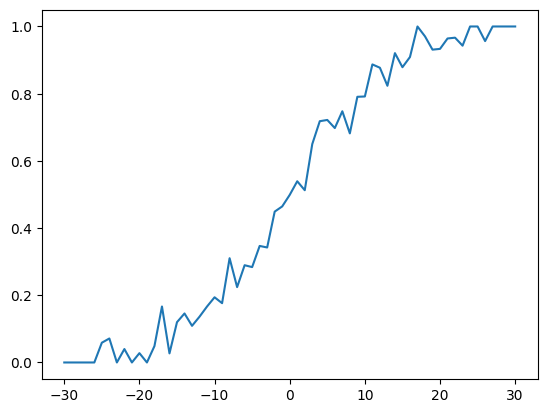

In [175]:
#oof_preds->예측된 점수 차이, np.where(y>0,1,0)-> 실제 경기 결과
#점수차이에 의한 승률 그래프 시각화
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [176]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0))) #점수차이와 실제 승패 묶음
    dat = sorted(dat, key = lambda x: x[0]) #예측된 점수 차이를 기준으로 정렬 / Spline의 경우 정렬되어 있어야 학습이 잘됨.
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5116592133068882
logloss of cvsplit 1: 0.512899671608367
logloss of cvsplit 2: 0.5117789975550949
logloss of cvsplit 3: 0.5130578404291789
logloss of cvsplit 4: 0.5112669456815007
logloss of cvsplit 5: 0.5131867916305277
logloss of cvsplit 6: 0.5127932078260086
logloss of cvsplit 7: 0.5126439640107581
logloss of cvsplit 8: 0.5128591287836068
logloss of cvsplit 9: 0.5123643056015968


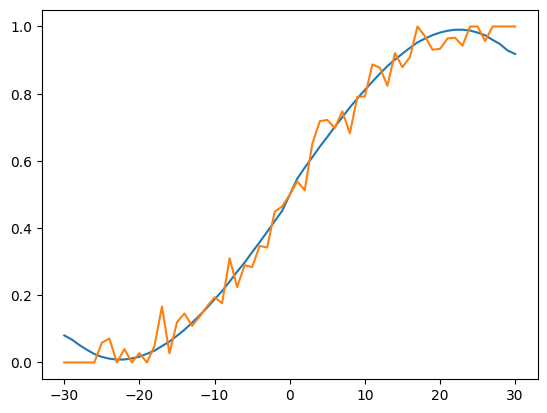

In [177]:

plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)


In [178]:
# spline_model = []

# for i in range(repeat_cv):
#     dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
#     dat = sorted(dat, key = lambda x: x[0])
#     datdict = {}
#     for k in range(len(dat)):
#         datdict[dat[k][0]]= dat[k][1]
#     spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
#     spline_fit = spline_model[i](oof_preds[i])
#     spline_fit = np.clip(spline_fit,0.025,0.975)
    
#     print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}")

In [179]:
# spline_model = []

# for i in range(repeat_cv):
#     dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
#     dat = sorted(dat, key = lambda x: x[0])
#     datdict = {}
#     for k in range(len(dat)):
#         datdict[dat[k][0]]= dat[k][1]
#     spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
#     spline_fit = spline_model[i](oof_preds[i])
#     spline_fit = np.clip(spline_fit,0.025,0.975)
#     spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
#     spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
#     spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
#     spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
#     spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
#     spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
#     spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
#     spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
#     print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

In [180]:
# #looking for upsets
# pd.concat(
#     [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
#      tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
# )   

In [181]:
# spline_model = []

# for i in range(repeat_cv):
#     dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
#     dat = sorted(dat, key = lambda x: x[0])
#     datdict = {}
#     for k in range(len(dat)):
#         datdict[dat[k][0]]= dat[k][1]
#     spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
#     spline_fit = spline_model[i](oof_preds[i])
#     spline_fit = np.clip(spline_fit,0.025,0.975)
#     spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
#     spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
#     spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
#     spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
#     spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
#     spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
#     spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
#     spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
#     print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

In [182]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4883660958982156
adjusted logloss of cvsplit 1: 0.4894307547416312
adjusted logloss of cvsplit 2: 0.48805145032785696
adjusted logloss of cvsplit 3: 0.4892917056414886
adjusted logloss of cvsplit 4: 0.48798276835229926
adjusted logloss of cvsplit 5: 0.4897403706084888
adjusted logloss of cvsplit 6: 0.4899943911835067
adjusted logloss of cvsplit 7: 0.4888125164948544
adjusted logloss of cvsplit 8: 0.48909119585052385
adjusted logloss of cvsplit 9: 0.4889346415475823


<ipython-input-182-f886cb18a96d>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.518990
2004    0.484451
2005    0.498960
2006    0.547091
2007    0.420963
2008    0.452467
2009    0.461105
2010    0.473752
2011    0.484792
2012    0.482505
2013    0.509107
2014    0.484861
2015    0.428258
2016    0.527675
2017    0.468494
2018    0.530275
2019    0.428457
2021    0.523906
2022    0.532951
2023    0.521831
2024    0.466051
dtype: float64

In [183]:
"""
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()
"""
sub = pd.read_csv(DATA_PATH + "SampleSubmissionStage2.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104
3,2025_1101_1105,0.5,2025,1101,1105
4,2025_1101_1106,0.5,2025,1101,1106


In [184]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, season_win_stats_T1, on=['Season', 'T1_TeamID'], how='left')
sub = pd.merge(sub, season_win_stats_T2, on=['Season', 'T2_TeamID'], how='left')
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,T1_win_ratio_season,T2_win_ratio_season,Seed_diff
0,2025_1101_1102,0.5,2025,1101,1102,67.551724,71.0,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,69.297161,57.21064,15.288932,61.937500,73.656250,21.250000,50.500000,8.093750,24.468750,5.937500,13.375000,12.187500,5.656250,17.843750,26.406250,54.937500,7.218750,19.906250,7.937500,12.843750,9.687500,6.812500,3.218750,-11.718750,64.178763,51.018145,24.191868,NaN,NaN,NaN,NaN,0.333333,0.0,0.448276,0.125000,NaN
1,2025_1101_1103,0.5,2025,1101,1103,67.551724,71.0,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,69.297161,57.21064,15.288932,83.968750,75.906250,30.218750,64.125000,10.656250,29.093750,9.968750,17.687500,11.750000,7.562500,18.281250,26.687500,61.375000,7.437500,23.343750,8.843750,11.937500,12.000000,7.187500,2.437500,8.062500,78.459173,60.419019,26.547883,NaN,1.106512,NaN,13.0,0.333333,1.0,0.448276,0.812500,NaN
2,2025_1101_1104,0.5,2025,1101,1104,67.551724,71.0,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,69.297161,57.21064,15.288932,91.121212,81.424242,31.090909,64.424242,10.424242,29.787879,10.969697,16.787879,12.121212,6.060606,19.030303,28.909091,68.090909,7.363636,23.909091,10.333333,12.666667,10.060606,7.818182,4.242424,9.696970,89.506684,64.163102,29.948474,NaN,4.174627,NaN,2.0,0.333333,0.5,0.448276,0.757576,NaN
3,2025_1101_1105,0.5,2025,1101,1105,67.551724,71.0,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,69.297161,57.21064,15.288932,69.310345,79.896552,23.137931,59.793103,7.655172,24.862069,11.344828,12.344828,15.103448,8.000000,21.310345,26.551724,56.517241,8.275862,21.206897,9.724138,15.344828,14.137931,9.068966,3.034483,-10.586207,68.881940,57.555643,20.438105,NaN,NaN,NaN,NaN,0.333333,0.0,0.448276,0.241379,NaN
4,2025_1101_1106,0.5,2025,1101,1106,67.551724,71.0,24.206897,56.241379,4.103448,14.206897,8.655172,12.482759,14.206897,10.034483,21.448276,23.655172,51.310345,5.448276,16.689655,8.758621,12.206897,16.034483,7.896552,4.689655,-3.448276,69.297161,57.21064,15.288932,72.181818,72.484848,25.121212,62.787879,8.848485,26.909091,9.333333,11.393939,8.727273,7.636364,18.212121,24.818182,56.757576,7.484848,22.393939,9.151515,12.484848,12.060606,5.242424,3.272727,-0.303030,68.519453,62.637809,24.929258,NaN,0.261039,NaN,16.0,0.333333,1.0,0.448276,0.545455,NaN


In [185]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [186]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [187]:
import pandas as pd

# ✅ 기존 ScoreDiff 유지 (변동 없음)
predicted_score_diff = np.mean(
    [sub_models[i].predict(dtest) for i in range(repeat_cv)], axis=0
)

# ✅ 기존 제출된 Pred 값을 유지한 채 ScoreDiff 추가
sub["ScoreDiff"] = predicted_score_diff  

# ✅ 특정 ID(예: 2025_3106_3163) 검색하여 Pred와 ScoreDiff 비교
target_id = "2025_3106_3163"
analysis_df = sub[sub["ID"] == target_id]

analysis_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,T1_win_ratio_season,T2_win_ratio_season,Seed_diff,ScoreDiff
67910,2025_3106_3163,0.5,2025,3106,3163,48.035714,71.678571,16.785714,54.321429,3.607143,16.107143,10.535714,8.428571,19.678571,7.178571,18.0,25.785714,59.678571,6.892857,20.964286,11.928571,15.714286,15.107143,11.25,3.642857,-23.642857,50.916133,54.060523,16.068131,80.823529,51.852941,31.764706,62.470588,8.558824,22.705882,8.411765,20.911765,10.470588,11.235294,12.588235,19.294118,54.941176,6.5,22.117647,6.735294,11.029412,16.970588,5.235294,2.117647,28.970588,79.660576,61.467023,20.708705,NaN,1.316041,NaN,2.0,0.0,1.0,0.142857,0.911765,NaN,-47.349201


In [188]:
sub_preds = []
for i in range(repeat_cv):
    # sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    #sub_preds.append(spline_model[i](sub_models[i].predict(dtest)))
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest), -30, 30)), 0, 1))

sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
sub.loc[sub["ScoreDiff"] >= 23, "Pred"] = 1.0
sub.loc[sub["ScoreDiff"] <= -23, "Pred"] = 0.0
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0

"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("real_final_overriding_no_clip.csv", index = None)

In [189]:
filtered_df = sub[sub["ScoreDiff"].between(-23.3, -23)]
filtered_df[['Pred', 'ScoreDiff']]

,Pred,ScoreDiff
1715,0.0,-23.143993
2529,0.0,-23.103260
3138,0.0,-23.204170
4215,0.0,-23.269545
4795,0.0,-23.038481
...,...,...
128376,0.0,-23.251865
128879,0.0,-23.047722
129213,0.0,-23.083807
130472,0.0,-23.045462


In [190]:
print(sub["ScoreDiff"].sort_values().head(20))  # 가장 작은 값 20개 출력
print(sub["ScoreDiff"].sort_values().tail(20))  # 가장 큰 값 20개 출력


67910    -47.349201
70722    -47.070534
81330    -46.906487
73809    -46.625069
68972    -46.435223
68619    -46.225311
78450    -46.059315
80379    -45.841690
79419    -45.778191
88236    -45.466751
75155    -45.462471
114836   -45.358479
72447    -45.325157
78125    -45.293674
80697    -45.273975
116601   -45.218967
117941   -44.911972
119061   -44.828815
76154    -44.734402
114859   -44.528381
Name: ScoreDiff, dtype: float32
129641    37.039822
84464     37.069340
126546    37.380203
84600     37.512634
128502    37.670612
126514    37.677071
120207    38.367954
126501    38.478893
84664     38.982170
126460    39.114937
130107    39.517906
84700     40.400085
84732     40.811531
129671    40.953094
128532    41.105438
84687     41.925957
126531    42.171974
84646     42.688522
84489     43.368729
84717     44.651546
Name: ScoreDiff, dtype: float32


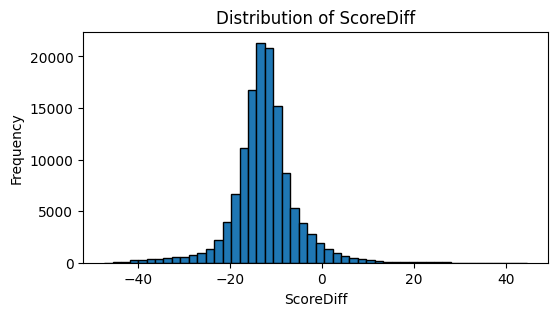

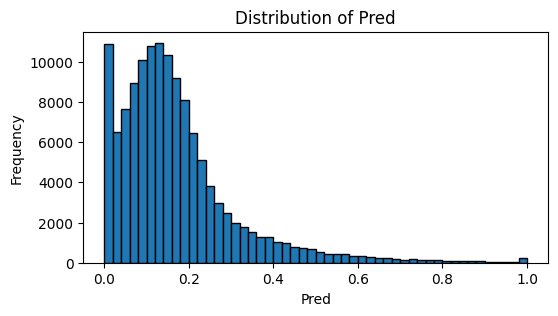

In [191]:
import matplotlib.pyplot as plt

# ScoreDiff 히스토그램
plt.figure(figsize=(6, 3))
plt.hist(sub["ScoreDiff"], bins=50, edgecolor="black")
plt.title("Distribution of ScoreDiff")
plt.xlabel("ScoreDiff")
plt.ylabel("Frequency")
plt.show()

# Pred 히스토그램
plt.figure(figsize=(6, 3))
plt.hist(sub["Pred"], bins=50, edgecolor="black")
plt.title("Distribution of Pred")
plt.xlabel("Pred")
plt.ylabel("Frequency")
plt.show()


In [192]:
sub[sub['ID']=="2025_3106_3163"]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Score_mean,T1_opponent_Score_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_OR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_OR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_PointDiff_mean,T1_Score_mean_mn3s,T1_FGA_mean_mn3s,T1_FGA3_mean_mn3s,T2_Score_mean,T2_opponent_Score_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_OR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_OR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_PointDiff_mean,T2_Score_mean_mn3s,T2_FGA_mean_mn3s,T2_FGA3_mean_mn3s,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,T1_win_ratio_season,T2_win_ratio_season,Seed_diff,ScoreDiff
67910,2025_3106_3163,0.0,2025,3106,3163,48.035714,71.678571,16.785714,54.321429,3.607143,16.107143,10.535714,8.428571,19.678571,7.178571,18.0,25.785714,59.678571,6.892857,20.964286,11.928571,15.714286,15.107143,11.25,3.642857,-23.642857,50.916133,54.060523,16.068131,80.823529,51.852941,31.764706,62.470588,8.558824,22.705882,8.411765,20.911765,10.470588,11.235294,12.588235,19.294118,54.941176,6.5,22.117647,6.735294,11.029412,16.970588,5.235294,2.117647,28.970588,79.660576,61.467023,20.708705,NaN,1.316041,NaN,2.0,0.0,1.0,0.142857,0.911765,NaN,-47.349201


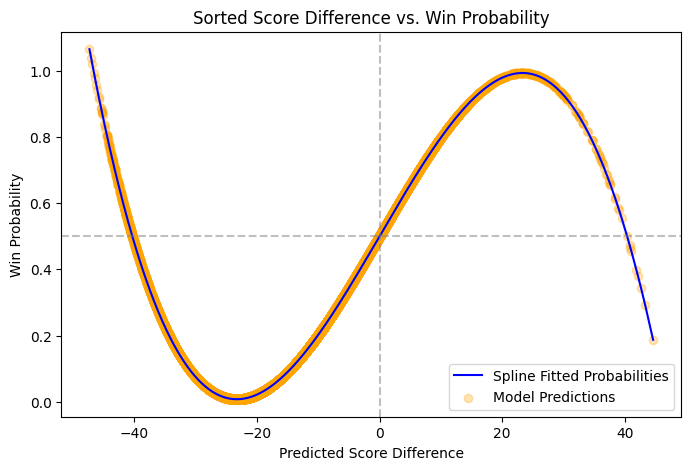

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1️⃣ 모델이 예측한 점수 차이값과 변환된 확률값 가져오기
predicted_score_diff = np.mean([np.clip(sub_models[i].predict(dtest), -50, 50) for i in range(repeat_cv)], axis=0)
predicted_win_prob = np.mean([spline_model[i](predicted_score_diff) for i in range(repeat_cv)], axis=0)

# 2️⃣ 데이터를 정렬하여 그래프를 그릴 수 있도록 변환
plot_df = pd.DataFrame({"ScoreDiff": predicted_score_diff, "WinProb": predicted_win_prob})
plot_df = plot_df.sort_values("ScoreDiff")  # X축(점수 차이)을 정렬

# 3️⃣ 그래프 그리기
plt.figure(figsize=(8, 5))

# 스플라인 변환된 확률
plt.plot(plot_df["ScoreDiff"], plot_df["WinProb"], label="Spline Fitted Probabilities", color='blue')

# 모델이 예측한 원본 점수 차이 & 확률
plt.scatter(plot_df["ScoreDiff"], plot_df["WinProb"], alpha=0.3, color='orange', label="Model Predictions")

# 기준선 추가
plt.axhline(0.5, linestyle="--", color="gray", alpha=0.5)  # 50% 확률 기준선
plt.axvline(0, linestyle="--", color="gray", alpha=0.5)  # 점수 차이 0 기준선

plt.xlabel("Predicted Score Difference")
plt.ylabel("Win Probability")
plt.title("Sorted Score Difference vs. Win Probability")
plt.legend()
plt.show()


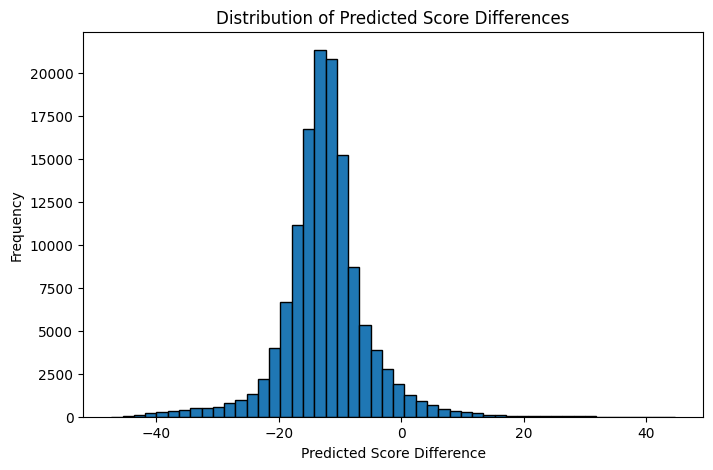

In [194]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(predicted_score_diff, bins=50, edgecolor="black")
plt.xlabel("Predicted Score Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Score Differences")
plt.show()

In [195]:
import pandas as pd

# 모델이 예측한 점수 차이와 변환된 확률 가져오기
predicted_score_diff = np.mean([np.clip(sub_models[i].predict(dtest), -30, 30) for i in range(repeat_cv)], axis=0)
predicted_win_prob = np.mean([spline_model[i](predicted_score_diff) for i in range(repeat_cv)], axis=0)

# 데이터프레임으로 정리
predictions_df = pd.DataFrame({"ScoreDiff": predicted_score_diff, "WinProb": predicted_win_prob})

# 정렬된 데이터 출력
predictions_df = predictions_df.sort_values("ScoreDiff")  # 점수 차이 기준으로 정렬
predictions_df

,ScoreDiff,WinProb
67946,-30.0,0.074835
120053,-30.0,0.074835
80922,-30.0,0.074835
80924,-30.0,0.074835
80927,-30.0,0.074835
...,...,...
84556,30.0,0.926553
105433,30.0,0.926553
24356,30.0,0.926553
120797,30.0,0.926553


In [196]:
def filter_win_prob(predictions_df, min_diff, max_diff):
    """
    특정 점수 차이 범위에 해당하는 승리 확률 조회 함수
    :param predictions_df: 점수 차이와 승리 확률 데이터프레임
    :param min_diff: 최소 점수 차이
    :param max_diff: 최대 점수 차이
    :return: 해당 범위 내의 데이터 출력
    """
    filtered_df = predictions_df[(predictions_df["ScoreDiff"] >= min_diff) & (predictions_df["ScoreDiff"] <= max_diff)]
    
    # 조회된 데이터가 많으면 상위 10개만 출력
    if len(filtered_df) > 10:
        print(f"조회된 데이터가 {len(filtered_df)}개 있습니다. 상위 10개만 출력합니다.\n")
        display(filtered_df.head(10))
    else:
        display(filtered_df)

# ✅ 예제: -5 ~ 5 사이의 점수 차이에 대한 승리 확률 조회
filter_win_prob(predictions_df, 23.30, 24.3)


조회된 데이터가 17개 있습니다. 상위 10개만 출력합니다.



,ScoreDiff,WinProb
116794,23.348330,0.992638
84622,23.358566,0.992637
131019,23.369648,0.992636
1352,23.385914,0.992634
84482,23.410095,0.992630
106182,23.421135,0.992628
28541,23.439445,0.992623
67408,23.460350,0.992617
128529,23.499207,0.992602
73215,23.647411,0.992505


In [197]:
# 두 값이 동일한지 비교
comparison_df = pd.DataFrame({
    "ID": sub["ID"],  # 제출 파일의 ID
    "Pred_in_submission": sub["Pred"],  # 최종 제출값
    "Pred_in_analysis": predictions_df["WinProb"]  # 위에서 분석한 승리 확률
})

# 차이가 있는 행만 필터링
diff_df = comparison_df[comparison_df["Pred_in_submission"] != comparison_df["Pred_in_analysis"]]

diff_df

,ID,Pred_in_submission,Pred_in_analysis
0,2025_1101_1102,0.159462,0.159446
1,2025_1101_1103,0.128908,0.128866
2,2025_1101_1104,0.010407,0.010396
3,2025_1101_1105,0.146305,0.146267
4,2025_1101_1106,0.089805,0.089778
...,...,...,...
131402,2025_3477_3479,0.155574,0.155445
131403,2025_3477_3480,0.063585,0.063564
131404,2025_3478_3479,0.151039,0.150915
131405,2025_3478_3480,0.052085,0.052069


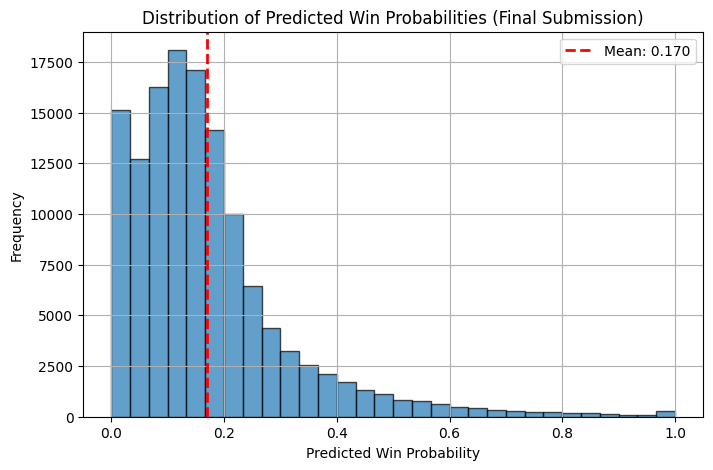

In [198]:
# 예측 확률 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(sub["Pred"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(sub["Pred"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean: {sub['Pred'].mean():.3f}")
plt.xlabel("Predicted Win Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Win Probabilities (Final Submission)")
plt.legend()
plt.grid(True)
plt.show()


In [199]:
win_counts_2025 = regular_season_effects.loc[regular_season_effects['Season']==2025, 'win'].value_counts()
print(win_counts_2025)
regular_season_effects.query("Season == 2025").groupby("T1_TeamID")['win'].mean().sort_values()


win
1    692
0    692
Name: count, dtype: int64


T1_TeamID
3456    0.000000
1110    0.000000
1188    0.000000
3361    0.000000
3380    0.000000
1136    0.000000
3333    0.000000
3293    0.000000
3192    0.000000
3250    0.000000
3251    0.000000
3219    0.000000
3195    0.000000
3193    0.000000
1270    0.000000
3206    0.000000
1285    0.000000
3422    0.000000
3123    0.000000
1407    0.000000
1423    0.000000
1459    0.000000
1384    0.000000
1303    0.000000
3436    0.000000
3378    0.142857
3235    0.166667
1314    0.166667
3313    0.250000
3166    0.250000
3449    0.250000
1106    0.250000
1124    0.266667
3435    0.285714
1462    0.300000
3199    0.300000
3280    0.307692
1257    0.333333
1161    0.333333
1435    0.333333
3453    0.333333
1252    0.333333
1400    0.350000
3332    0.352941
3304    0.352941
3257    0.357143
1208    0.368421
1211    0.375000
3234    0.375000
1458    0.384615
1280    0.388889
3279    0.400000
3143    0.400000
1313    0.400000
1242    0.400000
1112    0.411765
3231    0.411765
3210    0.416667
3343

ㅅ

In [200]:
team_quality(2025)

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


2.0851938371708147 1.4844047311792017


,TeamID,quality,Season
0,1103,1.106512,2025
1,1104,4.174627,2025
2,1106,0.261039,2025
3,1110,0.121843,2025
4,1112,2.452752,2025
5,1116,3.476693,2025
6,1120,4.098693,2025
7,1124,2.242882,2025
8,1136,0.426456,2025
9,1140,3.311341,2025


In [201]:
for i in range(repeat_cv):
    # Step 1: sub_models가 예측한 점수 차이 가져오기
    predicted_score_diff = np.clip(sub_models[i].predict(dtest), -30, 30)
    
    # Step 2: Spline 변환을 적용하여 확률 값으로 변환
    predicted_win_prob = spline_model[i](predicted_score_diff)

    # Step 3: 특정 점수 차이 이상만 필터링 (예: 20점 이상)
    mask = predicted_score_diff > 20
    
    print(f"\n=== Fold {i} ===")
    print("Predicted Score Differences (20+):", predicted_score_diff[mask])  # 예측된 점수 차이
    print("Converted Win Probabilities (20+):", predicted_win_prob[mask])  # 변환된 확률 값


=== Fold 0 ===
Predicted Score Differences (20+): [20.318405 20.453638 23.798641 20.430502 22.171873 20.832651 25.715237
 20.822247 27.321798 20.309862 20.86391  20.985167 22.889055 26.90643
 30.       25.98471  28.704144 26.11229  30.       23.779491 22.93349
 24.09942  24.361517 26.650122 23.592136 25.796364 23.02866  30.
 20.49784  20.173384 21.190456 21.900549 24.040138 21.044588 23.754034
 21.374868 27.693254 22.870644 20.696503 20.739513 20.202347 23.794195
 25.166405 23.630337 20.569218 23.433449 20.048632 26.503315 21.94148
 24.856447 30.       24.419767 23.509521 20.68517  20.466185 28.767147
 26.212868 28.918184 28.603535 30.       26.986975 24.104914 30.
 26.133419 30.       20.969316 25.59313  23.893257 28.601118 23.643648
 30.       22.203396 25.720047 21.93347  25.617813 30.       30.
 22.336061 22.404776 20.654814 23.838085 30.       24.490942 24.53042
 30.       21.688698 25.195875 30.       27.351454 23.277098 23.893047
 30.       30.       28.638409 30.       30.    

In [202]:
# ✅ 2024년 데이터만 새롭게 측정하기 위해 변수명을 다르게 설정

# 1️⃣ 학습 데이터에서 2024년 데이터를 제외 (새로운 변수 사용)
train_data_eval = tourney_data[tourney_data['Season'] < 2024]  # 2024년 제외
X_train_eval = train_data_eval[features].values
y_train_eval = train_data_eval['T1_Score'] - train_data_eval['T2_Score']

dtrain_eval = xgb.DMatrix(X_train_eval, label=y_train_eval)

# 2️⃣ 2024년 토너먼트 데이터만 사용하여 평가
df_2024_eval = tourney_data[tourney_data['Season'] == 2024]  # 2024년 토너먼트 경기만
X_2024_eval = df_2024_eval[features].values
dtest_2024_eval = xgb.DMatrix(X_2024_eval)

# 3️⃣ 모델 훈련 (새로운 모델 리스트 사용)
sub_models_eval = []
for i in range(repeat_cv):
    model_eval = xgb.train(params=param, dtrain=dtrain_eval, num_boost_round=iteration_counts[i])
    sub_models_eval.append(model_eval)

# 4️⃣ 예측 및 Brier Score 평가
preds_list_eval = []
for i in range(repeat_cv):
    margin_2024_eval = sub_models_eval[i].predict(dtest_2024_eval)
    margin_2024_eval = np.clip(margin_2024_eval, -30, 30)
    prob_2024_eval = spline_model[i](margin_2024_eval)
    prob_2024_eval = np.clip(prob_2024_eval, 0.0, 1)
    preds_list_eval.append(prob_2024_eval)

final_prob_2024_eval = np.mean(preds_list_eval, axis=0)

y_2024_eval = (df_2024_eval['T1_Score'] > df_2024_eval['T2_Score']).astype(int)
brier_2024_eval = np.mean((final_prob_2024_eval - y_2024_eval)**2)

# 5️⃣ 결과 출력
print("Brier Score for 2024 (re-evaluated):", brier_2024_eval)


Brier Score for 2024 (re-evaluated): 0.15889505171106486


In [203]:
# import optuna
# import xgboost as xgb

# def objective(trial):
#     param_opt = {
#         'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),  
#         'subsample': trial.suggest_float('subsample', 0.5, 0.8),  
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),  
#         'min_child_weight': trial.suggest_int('min_child_weight', 5, 30),
#         'gamma': trial.suggest_float('gamma', 2, 5),  
#         'max_depth': trial.suggest_int('max_depth', 3, 6),
#         'num_parallel_tree': 1,  
#         'eval_metric': 'mae'
#     }

#     dtrain = xgb.DMatrix(X_train_eval_2023, label=y_train_eval_2023)

#     cv_result = xgb.cv(
#         param_opt, dtrain, num_boost_round=1000, nfold=5, 
#         early_stopping_rounds=25, metrics=['mae'], as_pandas=True
#     )

#     return cv_result['test-mae-mean'].min()

# # ✅ Optuna 실행 (Brier Score를 최적화하는 방향으로)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # 50번 탐색 수행

# # ✅ 최적의 파라미터 적용
# param.update(study.best_params)
# print("🔥 최적화된 파라미터 적용 완료!")
# print(param)


In [204]:
param = {} 
# param['objective'] = 'reg:linear'  # 현재 사용하지 않음 (회귀 문제 아님)
param['eval_metric'] = 'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05  # 학습률 (기본 0.02 권장)
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10  # 병렬 트리 개수 (10 추천)
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3
param['verbosity'] = 1  # 최신 XGBoost에서는 사용 안 함 (경고 발생 가능)

# ✅ GPU 활성화 여부 확인 후 설정 적용
if USE_GPU:
    param.update({
        'tree_method': 'hist',
        'device' : 'cuda'  # GPU 사용하여 학습 가속화
    })

# ✅ 파라미터 출력 (GPU 활성화 여부 확인)
print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'verbosity': 1, 'tree_method': 'hist', 'device': 'cuda'}


In [205]:
# ✅ 2023년 기준으로 Brier Score 측정 (2023 대회 방식 적용)

# 1️⃣ 학습 데이터에서 2023년 데이터를 제외하고 학습
train_data_eval_2023 = tourney_data[tourney_data['Season'] < 2023]  # 2023년 제외
X_train_eval_2023 = train_data_eval_2023[features].values
y_train_eval_2023 = train_data_eval_2023['T1_Score'] - train_data_eval_2023['T2_Score']

dtrain_eval_2023 = xgb.DMatrix(X_train_eval_2023, label=y_train_eval_2023)

# 2️⃣ 2023년 토너먼트 데이터만 사용하여 평가
df_2023_eval = tourney_data[tourney_data['Season'] == 2023]  # 2023년 토너먼트 경기만
X_2023_eval = df_2023_eval[features].values
dtest_2023_eval = xgb.DMatrix(X_2023_eval)

# 3️⃣ 모델 훈련 (새로운 모델 리스트 사용)
sub_models_eval_2023 = []
for i in range(repeat_cv):
    model_eval_2023 = xgb.train(params=param, dtrain=dtrain_eval_2023, num_boost_round=iteration_counts[i])
    sub_models_eval_2023.append(model_eval_2023)

# 4️⃣ 예측 및 Brier Score 평가
preds_list_eval_2023 = []
for i in range(repeat_cv):
    margin_2023_eval = sub_models_eval_2023[i].predict(dtest_2023_eval)
    margin_2023_eval = np.clip(margin_2023_eval, -30, 30)
    prob_2023_eval = spline_model[i](margin_2023_eval)
    prob_2023_eval = np.clip(prob_2023_eval, 0.0, 1)
    preds_list_eval_2023.append(prob_2023_eval)

final_prob_2023_eval = np.mean(preds_list_eval_2023, axis=0)

y_2023_eval = (df_2023_eval['T1_Score'] > df_2023_eval['T2_Score']).astype(int)
final_prob_2023_eval[df_2023_eval["T1_Score"] - df_2023_eval["T2_Score"] >= 23] = 1.0
final_prob_2023_eval[df_2023_eval["T1_Score"] - df_2023_eval["T2_Score"] <= -23] = 0.0
final_prob_2023_eval[(df_2023_eval["T1_seed"] == 1) & (df_2023_eval["T2_seed"] == 16)] = 1.0
final_prob_2023_eval[(df_2023_eval["T1_seed"] == 16) & (df_2023_eval["T2_seed"] == 1)] = 0.0

brier_2023_eval = np.mean((final_prob_2023_eval - y_2023_eval)**2)

# 5️⃣ 결과 출력
print("Brier Score for 2023 (re-evaluated, 2023 Kaggle Style):", brier_2023_eval)


Brier Score for 2023 (re-evaluated, 2023 Kaggle Style): 0.16785748431506126


정규화 함수 추가 0.16835732642664575

In [206]:
0.17904065546131856
Brier Score for 2023 (re-evaluated, 2023 Kaggle Style): 0.17902283435384325 #clip제외


SyntaxError: invalid syntax (<ipython-input-206-85409becdbab>, line 2)

In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# ✅ Feature Importance 가져오기
importance = model.get_score(importance_type='weight')

# ✅ Feature 이름 매핑 (numpy 배열 대비 대응)
feature_names = features  # X가 numpy 배열이라면 직접 리스트 지정 필요
importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}

# ✅ 중요도 낮은 순으로 정렬
sorted_importance = sorted(importance_named.items(), key=lambda x: x[1])

# ✅ 하위 20개 Feature만 표시
bottom_n = 25
sorted_importance = sorted_importance[:bottom_n]

# ✅ 시각화
plt.figure(figsize=(12, 8))  # 그래프 크기 증가
plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance])
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance (Bottom 20 Features)', fontsize=16)
plt.yticks(fontsize=12)  # Y축 글자 크기 키우기
plt.show()


In [ ]:
feature_name = "T1_EFFG_mean"  # 조회하고 싶은 Feature 이름
importance_value = importance_named.get(feature_name, "Not Found")
print(f"Feature '{feature_name}' Importance Score:", importance_value)


In [ ]:
print("Stored Feature Names:", list(importance_named.keys()))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Feature 상관관계 계산
corr_matrix = X_train.corr()

# ✅ Heatmap 그리기
plt.figure(figsize=(12, 10))  # 그래프 크기 설정
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# ✅ 제목 설정
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()


0.18478807318518742 win 14d only 

0.18561450225244228 win 14d & 1 year 

0.18566757477124163 win 1year only
